# The CRISP-DM Data-Science Process for Personal Finance

CRISP-DM stands for Cross Industry Standard Process for Data Mining and describes the six phases in a data mining project.

- Business Understanding
- Data Understanding
- Prepare Data
- Data Modeling
- Evaluate the Results

The questions I want to address here are the following:

1. What companies share price have long-term positive momentum ?
2. What companies have the best balance sheet?
3. What does the chart show?

## Business and Data Understanding

90% of investors fail in the market (stat from quora). This is because large firms can buy order-flow from brokers, so traditional methods like the one I use here are perhaps outdated. Ultimately, data analysis is used to profile retail investors and analyze where people put their money. 

For this project I use the unofficail Finviz and Yahoo Finance API's to gather the data I'm interested in.

## Library Imports

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from finviz.screener import Screener
from datetime import datetime
from finviz.helper_functions.request_functions import http_request_get
from finviz.helper_functions.scraper_functions import get_table
import nest_asyncio
import seaborn as sns
import timeit

## Finviz Screener API

In [4]:
# Following three cells -> Code from https://github.com/mariostoev/finviz/blob/master/finviz/screener.py
# Parsing html with boutifulsoup4
# Get html from main filter page, ft=4 ensures all filters are present
hdr = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) "
    "Chrome/23.0.1271.64 Safari/537.11"
}
base_url = "https://finviz.com/screener.ashx" 
req = requests.get(base_url+"?ft=4", headers=hdr) 

In [5]:
html = req.text
# Parse html and locate table we are interested in.
# Use one of the text values and get the parent table from that
bs = BeautifulSoup(html, "html.parser")
filters_table = None
for td in bs.find_all("td"):
    if td.get_text().strip() == "Exchange":
        filters_table = td.find_parent("table")
if filters_table is None:
    raise Exception("Could not locate filter parameters")

In [6]:
 # Delete all div tags, we don't need them
for div in filters_table.find_all("div"):
    div.decompose()

# Populate dict with filtering options and corresponding filter tags
filter_dict = {}
td_list = filters_table.find_all("td")
for i in range(0, len(td_list) - 2, 2):
    current_dict = {}
    if td_list[i].get_text().strip() == "":
        continue

    # Even td elements contain filter name (as shown on web page)
    filter_text = td_list[i].get_text().strip()

    # Odd td elements contain the filter tag and options
    selections = td_list[i + 1].find("select")
    filter_name = selections.get("data-filter").strip()

    # Store filter options for current filter
    options = selections.find_all("option", {"value": True})
    for opt in options:
        # Encoded filter string
        value = opt.get("value").strip()

        # String shown in pull-down menu
        text = opt.get_text()

        # Filter out unwanted items
        if value is None or "Elite" in text:
            continue

        # Make filter string and store in dict
        current_dict[text] = f"{filter_name}_{value}"

    # Store current filter dict
    filter_dict[filter_text] = current_dict

In [7]:
# To know what I can filter with:
filter_dict

{'Exchange': {'Any': 'exch_',
  'AMEX': 'exch_amex',
  'NASDAQ': 'exch_nasd',
  'NYSE': 'exch_nyse'},
 'Index': {'Any': 'idx_', 'S&P 500': 'idx_sp500', 'DJIA': 'idx_dji'},
 'Sector': {'Any': 'sec_',
  'Basic Materials': 'sec_basicmaterials',
  'Communication Services': 'sec_communicationservices',
  'Consumer Cyclical': 'sec_consumercyclical',
  'Consumer Defensive': 'sec_consumerdefensive',
  'Energy': 'sec_energy',
  'Financial': 'sec_financial',
  'Healthcare': 'sec_healthcare',
  'Industrials': 'sec_industrials',
  'Real Estate': 'sec_realestate',
  'Technology': 'sec_technology',
  'Utilities': 'sec_utilities'},
 'Industry': {'Any': 'ind_',
  'Stocks only (ex-Funds)': 'ind_stocksonly',
  'Exchange Traded Fund': 'ind_exchangetradedfund',
  'Advertising Agencies': 'ind_advertisingagencies',
  'Aerospace & Defense': 'ind_aerospacedefense',
  'Agricultural Inputs': 'ind_agriculturalinputs',
  'Airlines': 'ind_airlines',
  'Airports & Air Services': 'ind_airportsairservices',
  'Alumin

## Gather data (list of companies)

In [8]:
# Get list of symbols
nest_asyncio.apply()
# Many possible ways of filtering. i.e. high float and volume
# float is the amount of stocks for sale, market cap includes assets being held
# current filter: country = canada, avg volume > 10000, optionable and shortable, price < 50
filter = ["geo_canada", "sh_avgvol_o10000", "sh_opt_optionshort", "sh_price_u50", ""]
stock_list = Screener(filters=filter, order='volume')
print ("%s symbols listed.\n" % len(stock_list))

100%|██████████| 8/8 [00:02<00:00,  3.83it/s]

149 symbols listed.



In [9]:
# print the list of stocks retrieved
for stock in stock_list:
    print(stock['Ticker'])

SCR
PCOM
MIST
NOA
FUSN
GAME
DRTT
PROF
CIXX
PDS
THTX
VS
CGAU
ACHV
IPA
BRAG
LOOP
GP
ABST
MDVL
VEV
EPIX
NMG
EMX
SWIR
WKSP
PYR
VQS
MMX
LMNL
SII
TIXT
CAE
ELYS
NEWP
TMQ
LGO
RPTX
DPRO
CLS
ORLA
BEP
GSS
EGLX
ATY
IMV
FTRP
RCI
SJR
APT
TAC
TNK
YVR
HITI
GAU
MTA
IMO
MERC
DTEA
GROY
TRIL
OR
MEOH
AAU
RFP
FTS
SA
MAG
VFF
GOOS
GIL
PVG
XENE
TRX
HUGE
CSIQ
PBA
BLU
AXU
NG
PLG
LEV
SILV
ABCL
TRQ
LICY
BHC
WPRT
SSRM
TU
AQN
SAND
EGO
IMAX
HBM
ZYME
KL
NEPT
SVM
TGB
ERF
EQX
SOLO
SLI
GFL
WPM
AGI
CNQ
PAAS
MOGO
VET
MUX
APTO
NXE
TMC
UROY
GPL
LAC
CPG
MFC
CRON
BLDP
FSM
GTE
EXK
AUPH
AG
MMAT
ENB
NGD
NAK
TECK
CCJ
ACB
OGI
BTG
CVE
AUY
SU
CGC
IAG
BITF
GOLD
KGC
DNN
HEXO
BB
HUT
ANY


## Finviz main functions to get stock info, news, insider buys, crypto and analyst recommendations

In [10]:
STOCK_URL = "https://finviz.com/quote.ashx"
NEWS_URL = "https://finviz.com/news.ashx"
CRYPTO_URL = "https://finviz.com/crypto_performance.ashx"
STOCK_PAGE = {}

def get_page(ticker):
    global STOCK_PAGE

    if ticker not in STOCK_PAGE:
        STOCK_PAGE[ticker], _ = http_request_get(
            url=STOCK_URL, payload={"t": ticker}, parse=True
        )


def get_stock(ticker):
    """
    Returns a pandas dataframe containing stock data.
    :param ticker: stock symbol
    :type ticker: str
    :return dataframe
    """

    get_page(ticker)
    page_parsed = STOCK_PAGE[ticker]

    title = page_parsed.cssselect('table[class="fullview-title"]')[0]
    keys = ["Ticker", "Company", "Sector", "Industry", "Country"]
    fields = [ticker]+[f.text_content() for f in title.cssselect('a[class="tab-link"]')]
    data = dict(zip(keys, fields))

    all_rows = [
        row.xpath("td//text()")
        for row in page_parsed.cssselect('tr[class="table-dark-row"]')
    ]

    for row in all_rows:
        for column in range(0, 11, 2):
            data[row[column]] = row[column + 1]

    return pd.DataFrame.from_dict(data, orient='index').transpose()


def get_news(ticker):
    """
    Returns a list of sets containing news headline and url
    :param ticker: stock symbol
    :return: list
    """

    get_page(ticker)
    page_parsed = STOCK_PAGE[ticker]
    rows = page_parsed.cssselect('table[id="news-table"]')[0].xpath('./tr[not(@id)]')

    results = []
    date = None
    for row in rows:
        raw_timestamp = row.xpath("./td")[0].xpath('text()')[0][0:-2]

        if len(raw_timestamp) > 8:
            parsed_timestamp = datetime.strptime(raw_timestamp, "%b-%d-%y %I:%M%p")
            date = parsed_timestamp.date()
        else:
            parsed_timestamp = datetime.strptime(raw_timestamp, "%I:%M%p").replace(
                year=date.year, month=date.month, day=date.day)

        results.append((
            parsed_timestamp.strftime("%Y-%m-%d %H:%M"),
            row.xpath("./td")[1].cssselect('a[class="tab-link-news"]')[0].xpath("text()")[0],
            row.xpath("./td")[1].cssselect('a[class="tab-link-news"]')[0].get("href"),
            row.xpath("./td")[1].cssselect('div[class="news-link-right"] span')[0].xpath("text()")[0][1:]
        ))

    return results

def get_insider(ticker):
    """
    Returns a list of dictionaries containing all recent insider transactions.
    :param ticker: stock symbol
    :return: list
    """

    get_page(ticker)
    page_parsed = STOCK_PAGE[ticker]
    table = page_parsed.cssselect('table[class="body-table"]')[0]
    headers = table[0].xpath("td//text()")
    data = [dict(zip(headers, row.xpath("td//text()"))) for row in table[1:]]

    return data

def get_all_news():
    """
    Returns a list of sets containing time, headline and url
    :return: list
    """

    page_parsed, _ = http_request_get(url=NEWS_URL, parse=True)
    all_dates = [
        row.text_content() for row in page_parsed.cssselect('td[class="nn-date"]')
    ]
    all_headlines = [
        row.text_content() for row in page_parsed.cssselect('a[class="nn-tab-link"]')
    ]
    all_links = [
        row.get("href") for row in page_parsed.cssselect('a[class="nn-tab-link"]')
    ]

    return list(zip(all_dates, all_headlines, all_links))


def get_crypto(pair):
    """
    :param pair: crypto pair
    :return: dictionary
    """

    page_parsed, _ = http_request_get(url=CRYPTO_URL, parse=True)
    page_html, _ = http_request_get(url=CRYPTO_URL, parse=False)
    crypto_headers = page_parsed.cssselect('tr[valign="middle"]')[0].xpath("td//text()")
    crypto_table_data = get_table(page_html, crypto_headers)

    return crypto_table_data[pair]


def get_analyst_price_targets(ticker, last_ratings=5):
    """
    Returns a list of dictionaries containing all analyst ratings and Price targets
     - if any of 'price_from' or 'price_to' are not available in the DATA, then those values are set to default 0
    :param ticker: stock symbol
    :param last_ratings: most recent ratings to pull
    :return: list
    """

    analyst_price_targets = []

    try:
        get_page(ticker)
        page_parsed = STOCK_PAGE[ticker]
        table = page_parsed.cssselect('table[class="fullview-ratings-outer"]')[0]

        for row in table:
            rating = row.xpath("td//text()")
            rating = [val.replace("→", "->").replace("$", "") for val in rating if val != '\n']
            rating[0] = datetime.strptime(rating[0], "%b-%d-%y").strftime("%Y-%m-%d")

            data = {
                "date":     rating[0],
                "category": rating[1],
                "analyst":  rating[2],
                "rating":   rating[3],
            }
            if len(rating) == 5:
                if "->" in rating[4]:
                    rating.extend(rating[4].replace(" ", "").split("->"))
                    del rating[4]
                    data["target_from"] = float(rating[4])
                    data["target_to"] = float(rating[5])
                else:
                    data["target"] = float(rating[4])

            analyst_price_targets.append(data)
    except Exception as e:
        # print("-> Exception: %s parsing analysts' ratings for ticker %s" % (str(e), ticker))
        pass

    return analyst_price_targets[:last_ratings]

In [40]:
#example
info = get_stock('tlry')
info

,Ticker,Company,Sector,Industry,Country,Index,P/E,EPS (ttm),Insider Own,Shs Outstand,...,Earnings,Payout,Avg Volume,Price,Recom,SMA20,SMA50,SMA200,Volume,Change
0,tlry,"Tilray, Inc.",Healthcare,Drug Manufacturers - Specialty & Generic,USA,-,-,-1.61,2.10%,449.40M,...,Oct 07 BMO,-,18.10M,10.07,2.80,-8.73%,-18.54%,-43.08%,"13,859,032",-1.66%


In [12]:
#example
news = get_all_news()
news

[('11:38PM',
  'Chinese property bonds firm after Kaisa and Sunac make coupon payments',
  'https://www.reuters.com/article/china-evergrande-debt/chinese-property-bonds-firm-after-kaisa-and-sunac-make-coupon-payments-idUSL4N2RF0M0'),
 ('11:35PM',
  'Rent the Runway targets valuation of up to $1.5 billion in IPO',
  'https://www.foxbusiness.com/markets/rent-the-runway-targets-valuation-of-up-to-1-5-billion-in-ipo'),
 ('11:31PM',
  "How Evergrande found itself on the wrong side of China's regulators",
  'https://www.cnbc.com/2021/10/19/how-evergrande-found-itself-on-the-wrong-side-of-chinas-regulators.html'),
 ('11:26PM',
  '‘CoComelon’ owner Moonbug weighs sale, IPO',
  'https://www.foxbusiness.com/markets/cocomelon-owner-moonbug-weighs-sale-ipo'),
 ('11:17PM',
  'China Begins Dollar Bond Sale Even as Evergrande Woes Fester',
  'https://www.bloomberg.com/news/articles/2021-10-19/china-begins-sale-of-four-part-dollar-bond-offering?srnd=markets-vp'),
 ('11:08PM',
  'Nikkei rises on tech b

In [13]:
len(news)

180

## Yahoo Finance API (get share price history)

In [12]:
# Everytime the yahoo finance page changes code needs to be updated if there's a bug
# Use "pip install yfinance --upgrade --no-cache-dir" and restart the notebook kernel
# Get symbols price history from yahoo finance (len(stock_list) API calls here)
# using timeit to see how long this takes
start = timeit.timeit()
ticker_history_dict = {}
for stock in stock_list:
    ticker_history_dict[stock['Ticker']] = yf.Ticker(stock['Ticker']).history(period = "max") 
end = timeit.timeit()
print(end - start)
ticker_history_dict

SCR
PCOM
MIST
NOA
FUSN
GAME
DRTT
PROF
CIXX
PDS
THTX
VS
CGAU
ACHV
IPA
BRAG
LOOP
GP
ABST
MDVL
VEV
EPIX
NMG
EMX
SWIR
WKSP
PYR
VQS
MMX
LMNL
SII
TIXT
CAE
ELYS
NEWP
TMQ
LGO
RPTX
DPRO
CLS
ORLA
BEP
GSS
EGLX
ATY
IMV
FTRP
RCI
SJR
APT
TAC
TNK
YVR
HITI
GAU
MTA
IMO
MERC
DTEA
GROY
TRIL
OR
MEOH
AAU
RFP
FTS
SA
MAG
VFF
GOOS
GIL
PVG
XENE
TRX
HUGE
CSIQ
PBA
BLU
AXU
NG
PLG
LEV
SILV
ABCL
TRQ
LICY
BHC
WPRT
SSRM
TU
AQN
SAND
EGO
IMAX
HBM
ZYME
KL
NEPT
SVM
TGB
ERF
EQX
SOLO
SLI
GFL
WPM
AGI
CNQ
PAAS
MOGO
VET
MUX
APTO
NXE
TMC
UROY
GPL
LAC
CPG
MFC
CRON
BLDP
FSM
GTE
EXK
AUPH
AG
MMAT
ENB
NGD
NAK
TECK
CCJ
ACB
OGI
BTG
CVE
AUY
SU
CGC
IAG
BITF
GOLD
KGC
DNN
HEXO
BB
HUT
ANY
-0.0015189400000110709


{'SCR':                  Open       High        Low      Close   Volume  Dividends  \
 Date                                                                         
 2014-01-10   2.207000   2.207000   2.207000   2.207000     1900          0   
 2014-01-13   2.207000   2.207000   2.207000   2.207000        0          0   
 2014-01-14   2.207000   2.207000   2.207000   2.207000        0          0   
 2014-01-15   2.207000   2.207000   2.207000   2.207000        0          0   
 2014-01-16   2.207000   2.207000   2.207000   2.207000        0          0   
 ...               ...        ...        ...        ...      ...        ...   
 2021-10-13  34.730000  35.189999  34.639999  34.889999  1265537          0   
 2021-10-14  35.110001  35.520000  35.090000  35.139999   462574          0   
 2021-10-15  35.480000  36.099998  35.430000  35.599998   657699          0   
 2021-10-18  35.529999  35.709999  35.250000  35.580002   700059          0   
 2021-10-19  35.580002  35.580002  35.580002 

## Prepare Data

I calculate and use percent gain to filter the data using the 75th percentile gain in the overall period.

Note: There is more data preparation after evaluating percent gain results.

In [142]:
# what companies have positive momentum?
def percent_gain(hist, num_days = 365):
    """Calculates the percent return for num_days in the past
    
    params: 
    - hist -> pandas dataframe of stock price history (open, low, high, close, volume, dividend, stock splits)
    - num_days -> integer num_days in the past
    
    return:
    - float percent gain/loss with 2 decimal places
    """
    if num_days == 'max' or len(hist) < num_days:
        num_days = len(hist)
    h = hist.tail(num_days) # df of wanted period of data
    price_old = h.iloc[0]['Close']
    return float("{:.2f}".format((h.iloc[num_days-1]['Close']-price_old)/price_old * 100))

In [158]:
# make dataframe for percent gain max, 5y, 1y, 3m, 1m
# 1. What stocks are rising the most? Which are falling? Which have long-term highest overall return?  
columns = ['Ticker', 'Name', 'Total Return (%)', '5y Return (%)', '1y Return (%)', '3m Return (%)', '1m Return (%)']
percent_gain_df = pd.DataFrame(columns = columns)


for stock in stock_list:
    ticker = stock['Ticker']
    percent_gain_df = percent_gain_df.append(
        pd.Series([ticker, 
                   stock['Company'],
                   percent_gain(ticker_history_dict[ticker],'max'),
                   percent_gain(ticker_history_dict[ticker],365*5),
                   percent_gain(ticker_history_dict[ticker],365),
                   percent_gain(ticker_history_dict[ticker],90),
                   percent_gain(ticker_history_dict[ticker],30)
                   ], 
                  index = columns), 
        ignore_index = True)
        
    
percent_gain_df                           

,Ticker,Name,Total Return (%),5y Return (%),1y Return (%),3m Return (%),1m Return (%)
0,PCOM,Points International Ltd.,66.50,-27.48,100.12,-1.49,1.78
1,MIST,Milestone Pharmaceuticals Inc.,-61.94,-61.94,158.85,0.34,0.17
2,NOA,North American Construction Group Ltd.,4.55,113.90,223.86,13.71,9.38
3,PDS,Precision Drilling Corporation,1262.87,214.59,10910.53,32.78,37.27
4,FUSN,Fusion Pharmaceuticals Inc.,-55.00,-55.00,-55.00,-5.20,-6.13
...,...,...,...,...,...,...,...
145,ANY,Sphere 3D Corp.,-97.15,-99.70,558.24,334.06,41.61
146,TMC,TMC the metals company Inc.,-48.78,-48.78,-48.78,-48.78,-48.78
147,DNN,Denison Mines Corp.,-70.92,9.92,213.04,9.09,30.91
148,GOLD,Barrick Gold Corporation,4043.18,7.24,-30.31,-22.72,-8.48


## Data Modeling and Evaluate the Result 

### Analysis: percent gain (analyze, model, visualize)

In [147]:
percent_gain_df.describe()

,Total Return (%),5y Return (%),1y Return (%),3m Return (%),1m Return (%)
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,792.556733,122.549733,237.884333,2.170933,8.958400
std,3733.360428,586.949454,1035.535150,112.505240,27.000586
min,-100.000000,-99.890000,-74.890000,-74.460000,-44.740000
25%,-43.867500,-44.250000,-3.775000,-30.090000,-5.245000
50%,71.885000,14.890000,40.540000,-15.725000,2.165000
75%,342.510000,79.605000,161.745000,5.430000,13.500000
max,41820.000000,6622.220000,11277.780000,1247.730000,189.660000


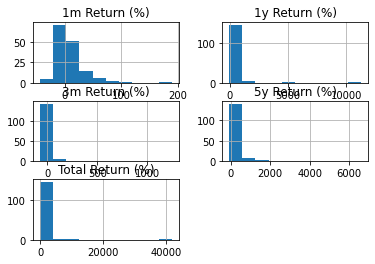

In [149]:
percent_gain_df.hist();

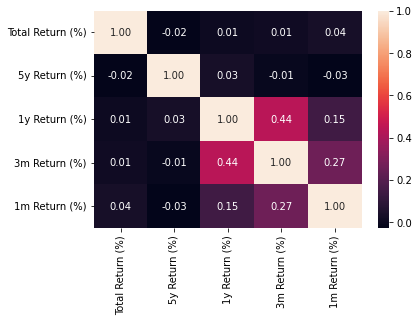

In [153]:
# shows mean reversion and trends are local
sns.heatmap(percent_gain_df.corr(), annot=True, fmt=".2f");

## 1. What companies share price have long-term positive momentum?

In [388]:
# shorten the company list filtering with percent change 
percent_filtered_df = percent_gain_df[(percent_gain_df['Total Return (%)']>342) & (percent_gain_df['1m Return (%)']>1)]
percent_filtered_df = percent_filtered_df.reset_index(drop=True)
percent_filtered_df

,Ticker,Name,Total Return (%),5y Return (%),1y Return (%),3m Return (%),1m Return (%)
0,PDS,Precision Drilling Corporation,1262.87,214.59,10910.53,32.78,37.27
1,CAE,CAE Inc.,466.48,145.80,112.12,-3.18,5.16
2,SJR,Shaw Communications Inc.,1026.05,52.68,92.85,-1.08,1.21
3,IMO,Imperial Oil Limited,2062.75,-29.04,165.36,1.07,29.41
4,WKSP,Worksport Ltd.,800.00,-28.00,4809.09,1048.94,7.78
5,MEOH,Methanex Corporation,683.84,-8.02,261.02,32.73,51.48
6,TRP,TC Energy Corporation,5186.02,43.45,16.96,-1.05,6.66
7,KL,Kirkland Lake Gold Ltd.,699.62,699.62,-0.36,-4.30,5.63
8,SCR,Score Media and Gaming Inc.,1476.02,939.70,1105.19,102.50,5.29
9,NXE,NexGen Energy Ltd.,1139.19,1562.12,250.36,3.40,21.75


## Prepare Data II

In this section I get stock info from Finviz using percent filtered data. Then I clean the info, select the metrics I'm interested in, calculate and filter with intrinsic value, and with the current ratio (current assets/current liabilities). Finally I create a dataframe to display what companies have the maximum and minimum values for each metric.

In [675]:
# Get symbols info from finviz html scrapper (len(percent_filtered_df) API calls here)
# using timeit to see how long this takes
start = timeit.timeit()
info_df = pd.DataFrame()
for ticker in percent_filtered_df["Ticker"]:
    if not info_df.empty:
        info_df = info_df.append(get_stock(ticker))
    else:
        info_df = get_stock(ticker)
        
end = timeit.timeit()
print(end - start)
info_df = info_df.reset_index(drop=True)
info_df

-0.014568891987437382


,Ticker,Company,Sector,Industry,Country,Index,P/E,EPS (ttm),Insider Own,Shs Outstand,...,Earnings,Payout,Avg Volume,Price,Recom,SMA20,SMA50,SMA200,Volume,Change
0,PDS,Precision Drilling Corporation,Energy,Oil & Gas Drilling,Canada,-,-,-10.70,1.00%,13.30M,...,Oct 21 BMO,-,42.75K,49.36,1.90,22.38%,39.11%,64.03%,"42,977",2.15%
1,CAE,CAE Inc.,Industrials,Aerospace & Defense,Canada,-,101.00,0.31,1.10%,293.60M,...,Aug 11 BMO,0.00%,242.90K,31.31,2.40,5.88%,6.34%,7.97%,"415,697",1.82%
2,SJR,Shaw Communications Inc.,Communication Services,Telecom Services,Canada,-,20.39,1.44,13.20%,499.00M,...,Oct 29 BMO,89.00%,205.66K,29.34,2.70,0.64%,0.83%,12.72%,"143,392",-0.51%
3,IMO,Imperial Oil Limited,Energy,Oil & Gas Integrated,Canada,-,-,-0.52,72.53%,724.10M,...,Jul 30 BMO,-,416.16K,34.63,3.30,9.95%,20.83%,28.54%,"925,667",1.32%
4,WKSP,Worksport Ltd.,Consumer Cyclical,Auto Parts,Canada,-,-,-0.38,21.80%,9.83M,...,-,-,650.59K,5.93,-,-5.94%,3.62%,-12.35%,"145,998",1.19%
5,MEOH,Methanex Corporation,Basic Materials,Chemicals,Canada,-,38.61,1.26,0.50%,76.21M,...,Oct 27 AMC,11.80%,334.09K,48.69,2.40,2.78%,20.73%,28.02%,"331,511",-2.37%
6,TRP,TC Energy Corporation,Energy,Oil & Gas Midstream,Canada,-,32.36,1.66,0.53%,979.00M,...,Jul 29 BMO,202.60%,1.37M,53.68,1.70,8.71%,10.66%,12.52%,"1,530,167",2.13%
7,KL,Kirkland Lake Gold Ltd.,Basic Materials,Gold,Canada,-,12.01,3.83,4.08%,267.07M,...,Jul 28 AMC,17.90%,1.74M,45.98,-,7.72%,11.60%,16.34%,"1,408,142",-0.80%
8,SCR,Score Media and Gaming Inc.,Communication Services,Electronic Gaming & Multimedia,Canada,-,-,-1.95,24.96%,47.84M,...,Jul 13 AMC,-,1.25M,35.60,-,2.86%,3.70%,44.14%,"657,699",1.31%
9,NXE,NexGen Energy Ltd.,Energy,Uranium,Canada,-,-,-0.42,16.15%,471.86M,...,-,-,2.40M,5.99,-,20.27%,25.32%,46.82%,"2,819,945",-2.44%


In [332]:
# examples
float(info_df['Market Cap'][0].strip('M'))*1000000/(float(info_df['Sales'][0].strip('M'))*1000000) # = P/S
# Book value of a company=Total assets−Total liabilities = total equity
float(info_df['Book/sh'][0])*(float(info_df['Shs Outstand'][0].strip('M'))*1000000) # book value

38135000.0

In [434]:
def clean(x):
    """ Clean DataFrame to be used with the panda Series apply() function. Removes M, B and % symbols and converts each cell to float data type"""
    if x[-1] == 'M':
        x = float(x.strip('M'))*1000000
    elif x[-1] == 'B':
        x = float(x.strip('B'))*1000000000
    elif x[-1] == '%':
        x = float(x.strip('%'))/100
    elif x != '-':
        x = float(x)
    return x

In [287]:
info_df.columns

Index(['Company', 'Sector', 'Industry', 'Country', 'Index', 'P/E', 'EPS (ttm)',
       'Insider Own', 'Shs Outstand', 'Perf Week', 'Market Cap', 'Forward P/E',
       'EPS next Y', 'Insider Trans', 'Shs Float', 'Perf Month', 'Income',
       'PEG', 'EPS next Q', 'Inst Own', 'Short Float', 'Perf Quarter', 'Sales',
       'P/S', 'EPS this Y', 'Inst Trans', 'Short Ratio', 'Perf Half Y',
       'Book/sh', 'P/B', 'ROA', 'Target Price', 'Perf Year', 'Cash/sh', 'P/C',
       'EPS next 5Y', 'ROE', '52W Range', 'Perf YTD', 'Dividend', 'P/FCF',
       'EPS past 5Y', 'ROI', '52W High', 'Beta', 'Dividend %', 'Quick Ratio',
       'Sales past 5Y', 'Gross Margin', '52W Low', 'ATR', 'Employees',
       'Current Ratio', 'Sales Q/Q', 'Oper. Margin', 'RSI (14)', 'Volatility',
       'Optionable', 'Debt/Eq', 'EPS Q/Q', 'Profit Margin', 'Rel Volume',
       'Prev Close', 'Shortable', 'LT Debt/Eq', 'Earnings', 'Payout',
       'Avg Volume', 'Price', 'Recom', 'SMA20', 'SMA50', 'SMA200', 'Volume',
       'Ch

In [690]:
# gather interested info and clean / transform data types (relevant info)
cols = ['Company', 'P/E', 'EPS (ttm)', 'Shs Outstand', 'Sales', 'P/S', 'Book/sh', 'P/B', 'ROA', 'Cash/sh', 'Dividend', 'Gross Margin', 'ATR', 'Current Ratio', 'Debt/Eq', 'Price']
rel_info_df = info_df[cols] # rel = relevant
rel_cols = ['P/E', 'EPS (ttm)', 'Shs Outstand', 'Sales', 'P/S', 'Book/sh', 'P/B', 'ROA', 'Cash/sh', 'Dividend', 'Gross Margin', 'ATR', 'Current Ratio', 'Debt/Eq', 'Price']
for col in rel_cols:
    rel_info_df[col] = rel_info_df[col].apply(lambda x: clean(x))
rel_info_df

/Users/philipleblanc/Projects/TradingBot/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Company,P/E,EPS (ttm),Shs Outstand,Sales,P/S,Book/sh,P/B,ROA,Cash/sh,Dividend,Gross Margin,ATR,Current Ratio,Debt/Eq,Price
0,Precision Drilling Corporation,-,-10.70,1.330000e+07,6.504e+08,0.99,77.90,0.63,-0.062,3.93,-,0.304,1.83,1.6,0.94,49.36
1,CAE Inc.,101,0.31,2.936000e+08,2.57e+09,3.79,8.75,3.58,0.014,1.79,-,0.273,0.69,1.3,0.74,31.31
2,Shaw Communications Inc.,20.39,1.44,4.990000e+08,4.43e+09,3.33,9.59,3.06,0.056,0.79,0.96,0.452,0.28,0.8,1.02,29.34
3,Imperial Oil Limited,-,-0.52,7.241000e+08,2.695e+10,1.11,28.68,1.21,-0.01,0.9,0.78,0.199,0.94,1.3,0.25,34.63
4,Worksport Ltd.,-,-0.38,9.830000e+06,400000,167.82,1.28,4.63,-0.416,1.09,-,0.051,0.53,9.0,0.02,5.93
5,Methanex Corporation,38.61,1.26,7.621000e+07,3.48e+09,1.1,18.55,2.62,0.017,9.77,0.5,0.185,1.92,2.1,2.04,48.69
6,TC Energy Corporation,32.36,1.66,9.790000e+08,1.056e+10,4.87,23.56,2.28,0.019,2.61,2.78,0.704,0.93,0.6,1.83,53.68
7,Kirkland Lake Gold Ltd.,12.01,3.83,2.670700e+08,3.14e+09,4.82,24.49,1.88,0.119,3.23,0.75,0.558,1.41,2.9,0.00,45.98
8,Score Media and Gaming Inc.,-,-1.95,4.784000e+07,2.3e+07,105.31,5.13,6.94,-0.61,-,-,0.131,0.86,11.9,0.09,35.60
9,NexGen Energy Ltd.,-,-0.42,4.718600e+08,-,-,0.93,6.44,-0.378,0.39,-,-,0.40,41.3,0.15,5.99


In [ ]:
# fill missing vals with 0 does not affect the validaty of the data, and make the describe() work better
rel_info_df = rel_info_df.replace('-',0)
rel_info_df

In [679]:
rel_info_df.describe()

,EPS (ttm),Shs Outstand,Book/sh,P/B,ATR,Current Ratio,Debt/Eq,Price
count,18.000000,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,-0.075000,6.161000e+08,17.441111,3.088889,0.972222,8.272222,0.607778,30.045556
std,3.029483,6.627831e+08,18.166493,2.179719,0.517603,15.500884,0.616580,15.672426
min,-10.700000,9.830000e+06,0.930000,0.630000,0.280000,0.600000,0.000000,4.990000
25%,-0.495000,1.219500e+08,5.250000,1.397500,0.547500,1.050000,0.105000,21.305000
50%,0.085000,3.827300e+08,14.070000,2.450000,0.895000,1.450000,0.500000,30.325000
75%,1.395000,9.152750e+08,23.505000,4.292500,1.357500,7.475000,0.890000,42.507500
max,3.830000,2.020000e+09,77.900000,7.940000,1.920000,56.700000,2.040000,53.680000


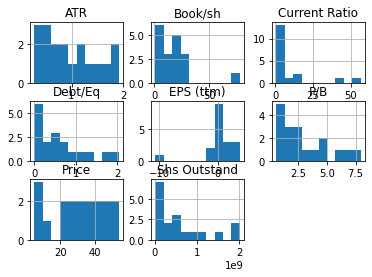

In [680]:
rel_info_df.hist();

### Calculate Intrinsic value

In [692]:
# # what companies have the best value?
# intrinsic value
# Intrinsic Value = P/E Ratio X Earnings Per Share

rel_info_df['P/E Intrinsic Value'] = rel_info_df['P/E'] * rel_info_df['EPS (ttm)']
rel_info_df['Undervalued (P/E)'] = rel_info_df['P/E Intrinsic Value']>rel_info_df['Price']

rel_info_df

,Company,P/E,EPS (ttm),Shs Outstand,Sales,P/S,Book/sh,P/B,ROA,Cash/sh,Dividend,Gross Margin,ATR,Current Ratio,Debt/Eq,Price,P/E Intrinsic Value,Undervalued (P/E)
0,Precision Drilling Corporation,0.00,-10.70,1.330000e+07,6.504000e+08,0.99,77.90,0.63,-0.062,3.93,0.00,0.304,1.83,1.6,0.94,49.36,-0.0000,False
1,CAE Inc.,101.00,0.31,2.936000e+08,2.570000e+09,3.79,8.75,3.58,0.014,1.79,0.00,0.273,0.69,1.3,0.74,31.31,31.3100,False
2,Shaw Communications Inc.,20.39,1.44,4.990000e+08,4.430000e+09,3.33,9.59,3.06,0.056,0.79,0.96,0.452,0.28,0.8,1.02,29.34,29.3616,True
3,Imperial Oil Limited,0.00,-0.52,7.241000e+08,2.695000e+10,1.11,28.68,1.21,-0.010,0.90,0.78,0.199,0.94,1.3,0.25,34.63,-0.0000,False
4,Worksport Ltd.,0.00,-0.38,9.830000e+06,4.000000e+05,167.82,1.28,4.63,-0.416,1.09,0.00,0.051,0.53,9.0,0.02,5.93,-0.0000,False
5,Methanex Corporation,38.61,1.26,7.621000e+07,3.480000e+09,1.10,18.55,2.62,0.017,9.77,0.50,0.185,1.92,2.1,2.04,48.69,48.6486,False
6,TC Energy Corporation,32.36,1.66,9.790000e+08,1.056000e+10,4.87,23.56,2.28,0.019,2.61,2.78,0.704,0.93,0.6,1.83,53.68,53.7176,True
7,Kirkland Lake Gold Ltd.,12.01,3.83,2.670700e+08,3.140000e+09,4.82,24.49,1.88,0.119,3.23,0.75,0.558,1.41,2.9,0.00,45.98,45.9983,True
8,Score Media and Gaming Inc.,0.00,-1.95,4.784000e+07,2.300000e+07,105.31,5.13,6.94,-0.610,0.00,0.00,0.131,0.86,11.9,0.09,35.60,-0.0000,False
9,NexGen Energy Ltd.,0.00,-0.42,4.718600e+08,0.000000e+00,0.00,0.93,6.44,-0.378,0.39,0.00,0.000,0.40,41.3,0.15,5.99,-0.0000,False


Taking the square root of a negative number is NaN therefore I fill NaN with 0 here.

In [ ]:
#  benjamin graham formula intrinsic value calculation
#  Maximum Intrinsic Value = Square root of (15 X 1.5 (Earnings per share) X(Book Value per share))

rel_info_df['BJM Intrinsic Value'] = np.sqrt(15 * 1.5 *rel_info_df['EPS (ttm)'] * rel_info_df['Book/sh'])
rel_info_df['BJM Intrinsic Value'] = rel_info_df['BJM Intrinsic Value'].fillna(0)
rel_info_df['Undervalued (BJM)'] = rel_info_df['BJM Intrinsic Value']>rel_info_df['Price']

rel_info_df.head()

In [ ]:
#  dividend discount model intrinsic value calculation
#  Value of Stock = Dividends per share/(Stockholders rate of return - dividend growth rate)
# rel_info_df['DDM Intrinsic Value'] = rel_info_df['Dividend'] / (1)
# rel_info_df['DDM Intrinsic Value'] = rel_info_df['DDM Intrinsic Value'].fillna(0)
# rel_info_df['Undervalued (DDM)'] = rel_info_df['DDM Intrinsic Value']>rel_info_df['Price']
# rel_info_df


In [694]:
# use current ratio to filter
current_df = rel_info_df[rel_info_df['Current Ratio']>2]
current_df = current_df.reset_index(drop=True)
current_df

,Company,P/E,EPS (ttm),Shs Outstand,Sales,P/S,Book/sh,P/B,ROA,Cash/sh,Dividend,Gross Margin,ATR,Current Ratio,Debt/Eq,Price,P/E Intrinsic Value,Undervalued (P/E),BJM Intrinsic Value,Undervalued (BJM)
0,Worksport Ltd.,0.00,-0.38,9830000.0,4.000000e+05,167.82,1.28,4.63,-0.416,1.09,0.00,0.051,0.53,9.0,0.02,5.93,-0.0000,False,0.000000,False
1,Methanex Corporation,38.61,1.26,76210000.0,3.480000e+09,1.10,18.55,2.62,0.017,9.77,0.50,0.185,1.92,2.1,2.04,48.69,48.6486,False,22.932346,False
2,Kirkland Lake Gold Ltd.,12.01,3.83,267070000.0,3.140000e+09,4.82,24.49,1.88,0.119,3.23,0.75,0.558,1.41,2.9,0.00,45.98,45.9983,True,45.939370,False
3,Score Media and Gaming Inc.,0.00,-1.95,47840000.0,2.300000e+07,105.31,5.13,6.94,-0.610,0.00,0.00,0.131,0.86,11.9,0.09,35.60,-0.0000,False,0.000000,False
4,NexGen Energy Ltd.,0.00,-0.42,471860000.0,0.000000e+00,0.00,0.93,6.44,-0.378,0.39,0.00,0.000,0.40,41.3,0.15,5.99,-0.0000,False,0.000000,False
5,Lithium Americas Corp.,0.00,-0.52,119860000.0,0.000000e+00,0.00,5.61,4.53,-0.092,4.36,0.00,0.000,1.65,56.7,0.29,25.43,-0.0000,False,0.000000,False
6,Aurinia Pharmaceuticals Inc.,0.00,-1.16,128220000.0,5.760000e+07,46.81,2.59,7.94,0.000,2.43,0.00,0.994,1.52,11.9,0.00,20.57,-0.0000,False,0.000000,False
7,Meta Materials Inc.,0.00,-0.38,197910000.0,1.300000e+06,1112.69,1.86,2.68,-0.377,0.53,0.00,0.968,0.42,2.6,0.01,4.99,-0.0000,False,0.000000,False


In [689]:
# find undervalued assets according to intrinsic value calculations
undervalued = rel_info_df[rel_info_df['Undervalued (P/E)'] | rel_info_df['Undervalued (BJM)']]
undervalued

,Company,P/E,EPS (ttm),Shs Outstand,Sales,P/S,Book/sh,P/B,ROA,Cash/sh,Dividend,Gross Margin,ATR,Current Ratio,Debt/Eq,Price,P/E Intrinsic Value,Undervalued (P/E),BJM Intrinsic Value,Undervalued (BJM)
2,Kirkland Lake Gold Ltd.,12.01,3.83,267070000.0,3.140000e+09,4.82,24.49,1.88,0.119,3.23,0.75,0.558,1.41,2.9,0.0,45.98,45.9983,True,45.93937,False


In [687]:
# find the companies with the max and min of each metric being investigated
columns1=['Company', 'metric', 'max_val']
max_df = pd.DataFrame(columns=columns1)
columns2=['Company', 'metric', 'min_val']
min_df = pd.DataFrame(columns=columns2)

for col, val in dict(undervalued.iloc[:,1:15].max()).items():
    
    max_df = max_df.append(
        pd.Series([undervalued[undervalued[col]==val]['Company'].values[0], 
                   col,
                   val], 
                  index = columns1), 
        ignore_index = True)
    
for col, val in dict(undervalued.iloc[:,1:15].min()).items():

    min_df = min_df.append(
        pd.Series([undervalued[undervalued[col]==val]['Company'].values[0], 
                   col,
                   val], 
                  index = columns2), 
        ignore_index = True)

max_min_df = pd.concat([min_df,max_df], axis=1)

## 2. What companies have the best balance sheet?

In [688]:
max_min_df

,Company,metric,min_val,Company,metric,max_val
0,Kirkland Lake Gold Ltd.,P/E,1.201000e+01,Kirkland Lake Gold Ltd.,P/E,1.201000e+01
1,Kirkland Lake Gold Ltd.,EPS (ttm),3.830000e+00,Kirkland Lake Gold Ltd.,EPS (ttm),3.830000e+00
2,Kirkland Lake Gold Ltd.,Shs Outstand,2.670700e+08,Kirkland Lake Gold Ltd.,Shs Outstand,2.670700e+08
3,Kirkland Lake Gold Ltd.,Sales,3.140000e+09,Kirkland Lake Gold Ltd.,Sales,3.140000e+09
4,Kirkland Lake Gold Ltd.,P/S,4.820000e+00,Kirkland Lake Gold Ltd.,P/S,4.820000e+00
5,Kirkland Lake Gold Ltd.,Book/sh,2.449000e+01,Kirkland Lake Gold Ltd.,Book/sh,2.449000e+01
6,Kirkland Lake Gold Ltd.,P/B,1.880000e+00,Kirkland Lake Gold Ltd.,P/B,1.880000e+00
7,Kirkland Lake Gold Ltd.,ROA,1.190000e-01,Kirkland Lake Gold Ltd.,ROA,1.190000e-01
8,Kirkland Lake Gold Ltd.,Cash/sh,3.230000e+00,Kirkland Lake Gold Ltd.,Cash/sh,3.230000e+00
9,Kirkland Lake Gold Ltd.,Dividend,7.500000e-01,Kirkland Lake Gold Ltd.,Dividend,7.500000e-01


In [589]:
# z and f score info

# https://www.investopedia.com/terms/a/altman.asp
# Altman Z-Score = 1.2A + 1.4B + 3.3C + 0.6D + 1.0E (likelyhood of bankruptcy)
# A score below 1.8 means it's likely the company is headed for bankruptcy
# Scores above 3 are not likely to go bankrupt

# Where:

# A = working capital / total assets
# B = retained earnings / total assets
# C = earnings before interest and tax / total assets
# D = market value of equity / total liabilities
# E = sales / total assets

# https://www.investopedia.com/terms/p/piotroski-score.asp
# Piotroski F-Score (best value = 9)

# Profitability criteria include:
# Positive net income (1 point)
# Positive return on assets in the current year (1 point)
# Positive operating cash flow in the current year (1 point)
# Cash flow from operations being greater than net Income (quality of earnings) (1 point)

# Leverage, liquidity, and source of funds criteria include:
# Lower ratio of long term debt in the current period, compared to the previous year (decreased leverage) (1 point)
# Higher current ratio this year compared to the previous year (more liquidity) (1 point)
# No new shares were issued in the last year (lack of dilution) (1 point).

# Operating efficiency criteria include:
# A higher gross margin compared to the previous year (1 point)
# A higher asset turnover ratio compared to the previous year (1 point)

## Technical Indicators, Bollinger Bands (BB), Moving Averages (MA's)


In [163]:
# plots
# visualize
# what does the chart show?
def plot_stock(symbol):
    """ Function to plot a stock using it's ticker symbol
    
    params:
    - symbol -> string ticker symbol
    return:
    - matplotlib figure
    """
    
    font1 = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 16,
            }
    font2 = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 14,
            }
    
    # calculations
    # typical price
    ticker_history_dict[symbol]['tp'] = (ticker_history_dict[symbol]['High'] + ticker_history_dict[symbol]['Low'] + ticker_history_dict[symbol]['Close']) / 3
    m = 2  # num standard deviations
    # # 20/50/200-day simple moving avg
    ticker_history_dict[symbol]['50dma'] = ticker_history_dict[symbol]['tp'].rolling(50).mean()
    ticker_history_dict[symbol]['200dma'] = ticker_history_dict[symbol]['tp'].rolling(200).mean()
    ticker_history_dict[symbol]['20dma'] = ticker_history_dict[symbol]['tp'].rolling(20).mean()
    # moving standard deviation
    ticker_history_dict[symbol]['stdv'] = ticker_history_dict[symbol]['tp'].rolling(20).std()
    # upper/lower bollinger band
    ticker_history_dict[symbol]['bolu'] = ticker_history_dict[symbol]['20dma'] + (m * ticker_history_dict[symbol]['stdv'])  
    ticker_history_dict[symbol]['bold'] = ticker_history_dict[symbol]['20dma'] - (m * ticker_history_dict[symbol]['stdv'])
    
    # plot 3M with 50 & 200 day moving avg
    threeMonths = ticker_history_dict[symbol].tail(90)
    fig = plt.subplot(311)  # plot max, 1y (with bb), 3m (with ma)
    plt.title("%s Stock Price" % symbol, fontdict=font1)
    # moving avg crossing could be used for signals
    plt.plot(threeMonths.index, threeMonths['Close'].values, 'b-')
    plt.plot(threeMonths.index, threeMonths['200dma'].values, 'r-')  # more bearish
    plt.plot(threeMonths.index, threeMonths['50dma'].values, 'r-')
    plt.plot(threeMonths.index, threeMonths['20dma'].values, 'r-')  # more bullish
    # ax.set_xticks(threeMonths.index[[x for x in range(0,89,89//3)]])
    
    # 1 year with bollinger band
    year = ticker_history_dict[symbol].tail(365)
    fig =plt.subplot(312)
    plt.ylabel('Stock Close Price', fontdict=font2)
    plt.plot(year.index, year['Close'].values, 'b-')
    plt.plot(year.index, year['bolu'].values, 'r-')
    plt.plot(year.index, year['bold'].values, 'r-')
    # ax.set_xticks(year.index[[x for x in range(0, 364, 364//3)]])
    
    # max
    fig = plt.subplot(313)
    plt.plot(ticker_history_dict[symbol].index, ticker_history_dict[symbol]['Close'].values, 'b-')
    plt.xlabel('Date', fontdict=font2)
    # ax.set_xticks(hist.index[[x for x in range(0, len(hist), len(hist)//3)]])
    plt.show()
    return fig

## 3. What does the chart show?

The share price is above the 20-day and 50-day SMA (simple moving average), but below the 200-day SMA for the 3-month period and about constant. The one-year period is about constant and the price is inside the bollinger bands. The overall history is up-trending. 

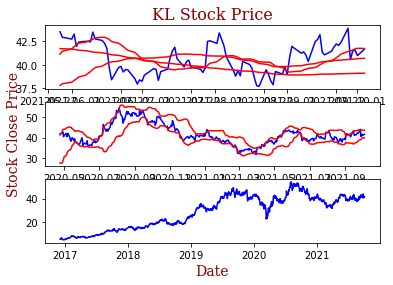

In [695]:
plot_stock('KL')

## Use stock news from Finviz 

In [ ]:
# can use stock to see if there is a relation to price change
# other useful finviz functions: get analyst target

## Portfolio tracking

In [41]:
# refactor and use a portfolio class
class Portfolio:
    """ 
    Class to analyze a watchlist of positions TODO
    """
    def __init__(self, positions, entry, quantity):
        """ Initialize with list of positions, entry price, and quantity"""
        # example portfolio
#         positions = ['tlry', 'gold', 'wmt', 'ac', 'l', 'cgx', 'vcn', 'xei', 'xqb', 'huv']
#         entry = [6.12, 2.32, 118.26, 22.28, 66.37, 33.95, 32.50, 16.95, 21.07, 149.81]
        self.positions = positions
        self.entry = entry
        self.quant = quantity # number of shares bought
        self.positions_dict = {'Symbol': positions, 'Entry': entry}
        self.positions_df = pd.DataFrame.from_dict(self.positions_dict)
        self.portfolio_size = 11000
        self.cash = 6000

    def add_position(self, position, entry):
        """ Append to dataframe"""
        #self.positions_df = self.positions_df.append(pd.DataFrame(pos))
        pass
    def remove_position(self, position):
        """ Drop row from dataframe"""
#         self.positions_df = self.positions_df.drop()
        pass